# Imports and Init

In [63]:
import numpy as np
import pandas as pd

from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.impute import SimpleImputer
import scipy.io as sio
from scipy.signal import savgol_filter
from scipy.io import savemat

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.amp import GradScaler, autocast

from einops import rearrange, repeat

from sklearn.metrics import r2_score, f1_score, recall_score, classification_report, accuracy_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier

import spectral
from spectral import open_image


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


In [7]:
hsi_path = '../datasets/Indian_pines_corrected.mat'
gt_path = '../datasets/Indian_pines_gt.mat'

egg_n2con_gt = '../datasets/Eggplant_Crop/Eggplant_N2_Concentration_GT.hdr'
egg_ref = '../datasets/Eggplant_Crop/Eggplant_Reflectance_Data.hdr'

In [8]:
ref = spectral.open_image(egg_ref).load()
ref_gt =  spectral.open_image(egg_n2con_gt).load()

In [9]:
name = 'Indian_pines_corrected'

gtd = loadmat(gt_path)
htd = loadmat(hsi_path)
hsi = htd[list(htd.keys())[3]]
gt = gtd[list(gtd.keys())[3]]

print(hsi.shape)
print(gt.shape)

(145, 145, 200)
(145, 145)


In [10]:
def generate_dummy(hsi):
    dummy_hsi = np.random.rand(*hsi.shape).astype(np.float32)

    dummy_hsi[:, :, 50:60] *= 1.2
    dummy_hsi[:, :, 30:40] *= 0.8

    dummy_gt = np.random.randint(0, 5, size=(145, 145))

    #nans
    dummy_hsi[100:110, 50:60, :] = np.nan
    dummy_hsi[:, :, 150] = np.nan

    return dummy_hsi, dummy_gt

hsi_dummy, gt_dummy = generate_dummy(hsi)
savemat(f'dummy_{name}.mat',
        {'hsi': hsi_dummy, 'gt': gt_dummy})

In [11]:
gtd

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:25:41 2011',
 '__version__': '1.0',
 '__globals__': [],
 'indian_pines_gt': array([[3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [12]:
nir_band = 100   # ~850 nm
red_band = 50    # ~670 nm
lambda700 = 110
lambda670 = 50
lambda550 = 30
lambda531 = 25
lambda570 = 35

nir = hsi[:, :, nir_band]
red = hsi[:, :, red_band]

ndvi = (nir - red) / (nir + red)

In [13]:
pca_n_components = 51
wavelengths = np.linspace(400, 2500, hsi.shape[2])
raw_spectra = np.random.rand(hsi.shape[0]*hsi.shape[1], hsi.shape[2]).astype(np.float32)

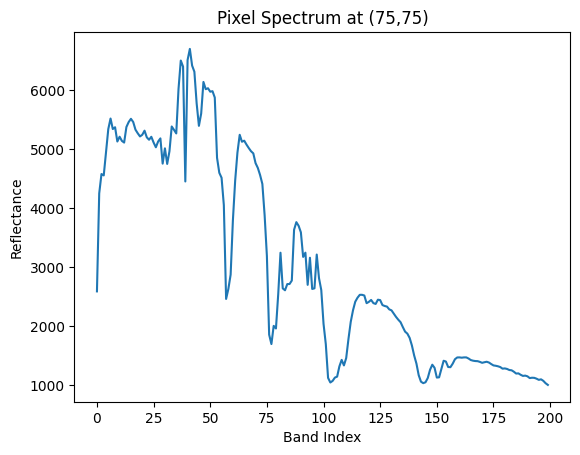

In [14]:
sample_spectrum = hsi[75, 75, :]

plt.plot(sample_spectrum)
plt.title("Pixel Spectrum at (75,75)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.show()


# Data Preprocessing

In [15]:
def apply_savgol(spectra):
    return savgol_filter(spectra, window_length=11, polyorder=2, axis=1, mode='nearest')

In [16]:
def log_transform(spectra):
    return np.log10(spectra + 1e-6)

## data loading

In [17]:
# hsi (H, W, C), gt (H, W)
H, W, C = hsi.shape
print(f"H: {H}, W: {W}, C: {C}")
flat_data = hsi.reshape(-1, C)
flat_gt = gt.reshape(-1)

print(f"Shape of flat_data: {flat_data.shape}")
print(f"Shape of flat_gt: {flat_gt.shape}")

train_mask = np.isin(flat_gt, [1, 2, 3]) # somewhat wrong
print(f"Train Mask: {train_mask} | Train Mask Shape : {train_mask.shape}")

X_train = flat_data[train_mask]
y_train = flat_gt[train_mask]
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

test_mask = flat_gt == 0
X_new = flat_data[test_mask]
print(f"test mask: {test_mask.shape}")
print(f"X_new: {X_new.shape}")


H: 145, W: 145, C: 200
Shape of flat_data: (21025, 200)
Shape of flat_gt: (21025,)
Train Mask: [ True  True  True ... False False False] | Train Mask Shape : (21025,)
X_train: (2304, 200)
y_train: (2304,)
test mask: (21025,)
X_new: (10776, 200)


## scaling | processing | pca fit

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=pca_n_components)
pca.fit_transform(X_train_scaled)

joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

pca = joblib.load('pca_model.pkl')
scaler = joblib.load('scaler.pkl')


## spectral preprocessor

In [19]:
class RobustSpectralPreprocessor:
    def __init__(self, pca_model_path='pca_model.pkl'):
        self.pca =joblib.load(pca_model_path)
        self.imputer = SimpleImputer(strategy='mean')  # NaN handler

    def _load_pca(self, path):
        return PCA(n_components=40)

    def process(self, raw_spectra):
        smoothed = savgol_filter(
            np.nan_to_num(raw_spectra),
            window_length=11,
            polyorder=2
        )
        print(f"smoothed shape: {smoothed.shape}")

        with np.errstate(invalid='ignore'):
            logged = np.log10(smoothed + 1e-6)
        print(f"logged shape: {logged.shape}")

        logged_clean = self.imputer.fit_transform(logged)
        print(f"logged_clean shape: {logged_clean.shape}")

        pca_reduced = self.pca.transform(logged_clean)
        print(f"pca_reduced shape: {pca_reduced.shape}")

        vis = self._calculate_vi(logged_clean)
        print(f"vis shape: {vis.shape}")

        return np.column_stack([pca_reduced, vis])

    def _calculate_vi(self, spectra):
        """NaN-safe vegetation index calculation"""
        red = spectra[:, 90]
        nir = spectra[:, 120]

        with np.errstate(divide='ignore', invalid='ignore'):
            ndvi = np.where(
                (nir + red) != 0,
                (nir - red) / (nir + red),
                0
            )
        return ndvi

## process data

In [20]:
# data = loadmat('dummy_indian_pines.mat')
# hsi, gt = data['hsi'], data['gt']

# Reshape(convert HSI cube to 2D)
n_pixels = 145 * 145
print(f"hsi shape: {hsi.shape}")
spectra = hsi.reshape(n_pixels, 200)  # Shape: (21025, 200)
print(f"spectra shape: {spectra.shape}")

# Process
preproc = RobustSpectralPreprocessor('pca_model.pkl')
processed = preproc.process(spectra)  # Output: (21025, 52)
print(f"preproc shape: {processed.shape}")

# Reshape back
processed_cube = processed.reshape(hsi.shape[0], hsi.shape[1], pca_n_components+1)

hsi shape: (145, 145, 200)
spectra shape: (21025, 200)
smoothed shape: (21025, 200)
logged shape: (21025, 200)
logged_clean shape: (21025, 200)
pca_reduced shape: (21025, 51)
vis shape: (21025,)
preproc shape: (21025, 52)


## test

In [21]:
def test_preprocessing():
    # hsi, _ = generate_dummy_indian_pines()
    spectra = hsi.reshape(-1, 200)
    print(f"spectra shape : {spectra.shape}")

    # Test 1: Handles cube-to-2D conversion
    preproc = RobustSpectralPreprocessor('pca_model.pkl')
    out = preproc.process(spectra)
    print(f"out shape : {out.shape}")
    assert out.shape == (hsi.shape[0]*hsi.shape[1], pca_n_components+1)

    # Test 2: Processes NaN bands correctly
    assert not np.isnan(out).any()

    # Test 3: Preserves spatial reconstructability
    out_cube = out.reshape(hsi.shape[0], hsi.shape[1], pca_n_components+1)
    # assert out_cube.shape == (145, 145, 41)

In [22]:
test_preprocessing()

spectra shape : (21025, 200)
smoothed shape: (21025, 200)
logged shape: (21025, 200)
logged_clean shape: (21025, 200)
pca_reduced shape: (21025, 51)
vis shape: (21025,)
out shape : (21025, 52)


# Feature Extraction

## spectralFeatureExtractor

In [23]:
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim=52, conv_dim=64, nhead=4):
        super().__init__()
        # 1D-CNN for local spectral patterns
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, conv_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Transformer for global dependencies
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=conv_dim,
                nhead=nhead,
                dim_feedforward=256,
                batch_first=True
            ),
            num_layers=2
        )

    def forward(self, x):
        # x shape: (batch, seq_len, features) -> (batch, 52, 145)
        x = x.permute(0, 2, 1)  # Conv1d expects (batch, channels, seq)
        x = self.conv(x)  # -> (batch, 64, 72)
        x = x.permute(0, 2, 1)  # -> (batch, 72, 64) for transformer
        return self.transformer(x)  # -> (batch, 72, 64)

# Multihead task Predictor

## Nutrient Head
- Regression

In [24]:
class NutrientHead(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # N, P, K values
        )

    def forward(self, x):
        # x: Transformer output (batch, seq, features)
        return self.regressor(x.mean(dim=1))  # Global avg pooling -> (batch, 3)

nutrient_loss = nn.HuberLoss(delta=1.0)

## Disease HEad
- Classification

In [25]:
class DiseaseHead(nn.Module):
    def __init__(self, input_dim=64, num_diseases=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_diseases)
        )
    def forward(self, x):
        return torch.sigmoid(self.classifier(x.mean(dim=1)))  # Multi-label

disease_loss = nn.BCELoss()

## Crop Identification
- Embedding

In [26]:
class CropEmbeddingHead(nn.Module):
    def __init__(self, input_dim=64, embed_dim=32):
        super().__init__()
        self.projection = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        # x: (batch, seq, features)
        return F.normalize(self.projection(x.mean(dim=1)), p=2.0, dim=1)  # L2-normalized

# Contrastive Loss (requires paired data)
crop_loss = nn.TripletMarginLoss(margin=1.0)  # anchor/positive/negative crops

# integrated Model

In [27]:
class AgriMultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = SpectralFeatureExtractor()
        self.nutrient_head = NutrientHead()
        self.disease_head = DiseaseHead()
        self.crop_head = CropEmbeddingHead()

    def forward(self, x):
        features = self.backbone(x)
        return {
            'nutrients': self.nutrient_head(features),
            'diseases': self.disease_head(features),
            'embeddings': self.crop_head(features)
        }

# Training Script

In [28]:
model = AgriMultiTaskModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def train_step(batch):
    spectra = batch['spectra']  # (batch, 52)
    targets = batch['targets']

    # Forward pass
    outputs = model(spectra)

    # Loss computation
    loss = (
        0.5 * nutrient_loss(outputs['nutrients'], targets['npk']) +
        0.3 * disease_loss(outputs['diseases'], targets['diseases']) +
        0.2 * crop_loss(
            outputs['embeddings'][::2],  # Anchors
            outputs['embeddings'][1::2], # Positives
            torch.roll(outputs['embeddings'], 1, dim=0)[::2]  # Negatives
        )
    )

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Deployment

## Edge devices

In [28]:
scripted_model = torch.jit.script(model)

quantized_model = torch.quantization.quantize_dynamic(
    scripted_model, {nn.Linear}, dtype=torch.qint8
)

torch.jit.save(quantized_model, "agri_model.pt")

## 5G-ONNX Export

In [29]:
dummy_input = torch.randn(1, 145, 52)  # Batch, seq_len, features
torch.onnx.export(
    model,
    dummy_input,
    "agri_model.onnx",
    input_names=["spectra"],
    output_names=["nutrients", "diseases", "embeddings"]
)

# Scoring

## Neutrient Score (R-squared)

In [29]:
print(f"ref shape: {ref.shape}")
print(f"n2 cont gt shape: {ref_gt.shape}")

ref shape: (545, 5382, 277)
n2 cont gt shape: (545, 5382, 1)


In [30]:
def load_and_preprocess_data():
    num_samples = 1000
    num_bands = 167 # (900 - 400) / 3
    
    dummy_ref = np.random.rand(num_samples, num_bands)
    dummy_gt = np.random.randint(1, 4, size = num_samples)
    
    return dummy_ref, dummy_gt

def reshape_hsd(ref, gt):
    # ref: (H, W, B)
    # gt: (H, W, 1)
    
    #return
    # X: (S, B)
    # y: (S)
    assert ref.shape[:2] == gt.shape[:2], \
        f"Ref - gt dim match: {ref.shape[:2]} - {gt.shape[:2]}"
    
    h, w, b = ref.shape
    
    X = ref.reshape(-1, b) # (pixels x bands)
    y = gt.reshape(-1) # (pixels)
    
    valid = ~np.isnan(y)
    X = X[valid]
    y = y[valid]
    
    unique_classes = np.unique(y)
    if not np.array_equal(unique_classes, np.arange(len(unique_classes))):
        class_mapping = {cls: i for i, cls in enumerate(unique_classes)}
        y = np.array([class_mapping[cls] for cls in y])
    
    return X, y, len(unique_classes)

In [49]:
# testing reshape
X, y, num_classes = reshape_hsd(ref, ref_gt)

print(f"X shape: {X.shape} | y shape: {y.shape}")


X shape: (2933190, 277) | y shape: (2933190,)


### ML model 1

In [31]:
def train_model(X, y):
    # X, y = load_and_preprocess_data()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    
    return model

In [32]:
print(f"device: {device}")

device: cuda


In [33]:
def train_model_L1(ref, gt, sample_size = 100000):
    X, y = reshape_hsd(ref, gt)
    
    if len(X) > sample_size:
        idx = np.random.choice(len(X), sample_size, replace = False)
        X = X[idx]
        y = y[idx]
        
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

In [34]:
# X, y = reshape_hsd(ref, ref_gt)
# model = train_model(X, y)

### Deep Learning

In [35]:
class NutrientNN_1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [36]:
def train_model_DL1(ref, gt, batch_size=4096, epochs = 20, val_split=0.2):
    X, y, num_classes = reshape_hsd(ref, gt)
    # X = X.get() if isinstance(X, np.ndarray) else X
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    X_tensor = torch.FloatTensor(X).cuda()
    y_tensor = torch.LongTensor(y).cuda()
    
    dataset = TensorDataset(X_tensor, y_tensor)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size)
    
    model = NutrientNN_1(X.shape[1], num_classes).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1e-4)
    
    schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
    
    train_losses = []
    val_accuracies = []
    best_accuracy = 0.0
    
    for epoch in (range(epochs)):
        
        model.train()
        epoch_losses = []
                
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
        # validation
        model.eval()
        correct = 0
        total = 0
            
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
        val_accuracy = correct/total
        avg_loss = np.mean(epoch_losses)
        
        schedular.step(val_accuracy)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model1.pth')
        
        train_losses.append(avg_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch+1}: Loss= {avg_loss:.4f} ||  Val Accuracy= {val_accuracy:.4f}')
            
    model.load_state_dict(torch.load('best_model1.pth'))
    
    return model, scaler, train_losses, val_accuracies

In [81]:
model_DL1, scaler_DL1, train_losses, val_accuracies = train_model_DL1(ref, ref_gt, batch_size=2048, epochs=10)

Epoch 1/10: 100%|██████████| 1146/1146 [01:01<00:00, 18.66it/s]


Epoch 1: Loss= 0.8412 ||  Val Accuracy= 0.6521


Epoch 2/10: 100%|██████████| 1146/1146 [00:49<00:00, 23.29it/s]


Epoch 2: Loss= 0.8231 ||  Val Accuracy= 0.6552


Epoch 3/10: 100%|██████████| 1146/1146 [00:49<00:00, 22.94it/s]


Epoch 3: Loss= 0.8151 ||  Val Accuracy= 0.6579


Epoch 4/10: 100%|██████████| 1146/1146 [00:55<00:00, 20.49it/s]


Epoch 4: Loss= 0.8102 ||  Val Accuracy= 0.6611


Epoch 5/10: 100%|██████████| 1146/1146 [00:59<00:00, 19.35it/s]


Epoch 5: Loss= 0.8061 ||  Val Accuracy= 0.6612


Epoch 6/10: 100%|██████████| 1146/1146 [00:52<00:00, 21.85it/s]


Epoch 6: Loss= 0.8032 ||  Val Accuracy= 0.6621


Epoch 7/10: 100%|██████████| 1146/1146 [00:54<00:00, 20.96it/s]


Epoch 7: Loss= 0.8003 ||  Val Accuracy= 0.6660


Epoch 8/10: 100%|██████████| 1146/1146 [01:01<00:00, 18.76it/s]


Epoch 8: Loss= 0.7980 ||  Val Accuracy= 0.6663


Epoch 9/10: 100%|██████████| 1146/1146 [00:59<00:00, 19.26it/s]


Epoch 9: Loss= 0.7954 ||  Val Accuracy= 0.6669


Epoch 10/10: 100%|██████████| 1146/1146 [00:59<00:00, 19.42it/s]


Epoch 10: Loss= 0.7940 ||  Val Accuracy= 0.6657


In [82]:
df = pd.DataFrame({
    'Losses:': train_losses,
    'Accuracies': val_accuracies
})

df.to_csv('NutrientNN3_e10.csv', index=True)

In [83]:
torch.save(model_DL1, "model3_e10.pth")

torch.save(model_DL1.state_dict(), "model3_weights_e10.pth")

In [84]:
torch.save({'scaler3': scaler}, 'scaler3_e10.pth')

### Test Nutr

In [97]:
X, y, num_classes = reshape_hsd(ref, ref_gt)


In [102]:
def predict_pixel(pixel_reflectance, model, scaler):
    
    pixel_scaled = scaler.transform(pixel_reflectance.reshape(1, -1))
    
    pixel_tensor = torch.FloatTensor(pixel_scaled).cuda()
    
    model.eval()
    with torch.no_grad():
        logits = model(pixel_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    return pred_class, probs.cpu().numpy().squeeze()

In [105]:
img = open_image(egg_ref)
cube = img.load()  

 

test_model_path = 'results/Nutrient/model3_weights_e10.pth'

test_scaler_path = 'results/Nutrient/scaler3_e10.pth'

In [118]:
test_pixel_ref = cube[200, 200, :] 

In [119]:
test_scaler_data = torch.load(test_scaler_path, weights_only=False)

test_scaler = test_scaler_data['scaler3']

test_model = NutrientNN_1(input_dim=X.shape[1], num_classes=num_classes).cuda()  
test_model.load_state_dict(torch.load(test_model_path))
test_model.eval()

NutrientNN_1(
  (net): Sequential(
    (0): Linear(in_features=277, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [120]:
class_label, probabilities = predict_pixel(test_pixel_ref, test_model, test_scaler)  # Pass model object, not path
print(f"Predicted class: {class_label}")
print(f"Class probabilities: {probabilities}")

Predicted class: 0
Class probabilities: [1.0000000e+00 2.9705347e-10 9.3026582e-09 4.0169677e-12]


## Disease (F1)

In [31]:
from transformers import TransformerClassifier

# y_diseases: (n_samples, n_diseases) - Multi-hot encoded labels

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=52):
        super().__init__()
        self.encoder = TransformerEncoderLayer(d_model=input_dim, nhead=4)
        self.classifier = nn.Linear(input_dim, 10)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x).mean(dim=1))

model = TransformerClassifier()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    outputs = model(X_train_tensor)
    loss = nn.BCELoss()(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

y_pred = (model(X_test_tensor).detach().numpy() > 0.5).astype(int)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"F1 Score: {f1:.3f}")

ImportError: cannot import name 'TransformerClassifier' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

## Crop (recall k)

In [ ]:
# embeddings: (n_samples, 32) - From contrastive head
# y_crop: (n_samples,) - Crop type labels

knn = NearestNeighbors(n_neighbors=5).fit(X_train_embeddings)

_, indices = knn.kneighbors(X_test_embeddings)
pred_labels = y_train[indices.flatten()].reshape(-1, 5)

recall_at_5 = np.mean([true in pred for true, pred in zip(y_test, pred_labels)])

print(f"Recall@5: {recall_at_5:.1%}")

### Evaluate Model

In [ ]:
def evaluate_model(model, X_test, y_test_nutrients, y_test_diseases, y_test_crops):
    outputs = model(X_test)

    r2 = r2_score(y_test_nutrients, outputs['nutrients'].detach().numpy())

    disease_pred = (outputs['diseases'].detach().numpy() > 0.5).astype(int)
    f1 = f1_score(y_test_diseases, disease_pred, average='macro')

    knn = NearestNeighbors(n_neighbors=5).fit(training_embeddings)
    _, indices = knn.kneighbors(outputs['embeddings'].detach().numpy())
    recall = np.mean([y_test_crops[i] in y_train_crops[indices[i]] for i in range(len(y_test_crops))])

    return {'r2': r2, 'f1': f1, 'recall@5': recall}

### Confidence Interval via bootstraping

In [ ]:
from sklearn.utils import resample
r2_scores = [r2_score(*resample(y_test, y_pred)) for _ in range(1000)]
print(f"R² CI: {np.percentile(r2_scores, [2.5, 97.5])}")

### SpectralFeatEx for 200 band input

In [17]:
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim=200, conv_dim=64):
        super().__init__()
        # (batch, channels, seq_len)
        self.conv = nn.Sequential(
            nn.Conv1d(1, conv_dim, kernel_size=3, padding=1),  # Single channel input
            nn.ReLU()
        )
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=conv_dim,
                nhead=4,
                batch_first=True
            ),
            num_layers=2
        )

    def forward(self, x):
        # Input shape: (batch, seq_len) -> (batch, 200)
        x = x.unsqueeze(1)  # -> (batch, 1, 200) [channels=1]
        x = self.conv(x)  # -> (batch, 64, 200)
        x = x.permute(0, 2, 1)  # -> (batch, 200, 64) for transformer
        return self.transformer(x)


### data init

In [127]:
hsi.shape

(145, 145, 200)

In [42]:
valid_mask = gt != 0

X = hsi[valid_mask]
y = gt[valid_mask] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [44]:
batch_size = 64
test_batch = 128

In [45]:
train_data = TensorDataset(
    torch.FloatTensor(X_train).to(device),
    torch.LongTensor(y_train).to(device)
)
test_data = TensorDataset(
    torch.FloatTensor(X_test).to(device),
    torch.LongTensor(y_test).to(device)
)

In [46]:
train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True,
                         )

test_loader = DataLoader(test_data,
                        batch_size=test_batch,
                        )

# train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_data, batch_size = 128)

# train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
# test_loader = DataLoader(test_data, batch_size = 512)

In [47]:


class CropClassifierHead(nn.Module):
  def __init__(self, input_dim=64, num_classes=16):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.fc(x.mean(dim=1))

# nn.Linear(200, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.5),

#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU()


# class CropClassifierHead(nn.Module):
#   def __init__(self, input_dim=64, num_classes=16):
#     super().__init__()
#     self.fc = nn.Sequential(
#         nn.Linear(input_dim, 128),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.Dropout(0.3),
#         nn.Linear(128, 64),
#         nn.BatchNorm1d(64),
#         nn.ReLU(),
#         nn.Dropout(0.3),
#         nn.Linear(64, num_classes)
#     )

#   def forward(self, x):
#     return self.fc(x.mean(dim=1))

In [123]:
class EnhancedCropModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(200, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.classifier = nn.Linear(64, 16)

    def forward(self, x):
        return self.classifier(self.backbone(x))

In [124]:
class EnhancedCropModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Input: 200 → 256
            nn.Linear(200, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            # 256 → 128
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.1),

            # 128 → 64
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            # 64 → 16 (classifier)
            nn.Linear(64, 16)
        )

    def forward(self, x):
        return self.net(x)


In [50]:
class ResidualFCBlock(nn.Module):
    """
    A small 2-layer MLP with LayerNorm + LeakyReLU, whose output is added back to its input.
    Assumes in_dim == hidden_dim == out_dim.
    """
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.lin1 = nn.Linear(dim, dim)
        self.ln1 = nn.LayerNorm(dim)
        self.lin2 = nn.Linear(dim, dim)
        self.ln2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        # x: (batch, dim)
        residual = x
        out = self.lin1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.lin2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        return out + residual


class SEBlock(nn.Module):
    """
    A very lightweight “Squeeze-and-Excitation” gating for a 1-D feature vector.
    Takes a (batch, C) tensor, passes it through two small MLP layers,
    applies sigmoid to get a (batch, C) gating vector, and multiplies back.
    """
    def __init__(self, channels, reduction=4):
        super().__init__()
        hidden = channels // reduction
        self.fc1 = nn.Linear(channels, hidden)
        self.act1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(hidden, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch, channels)
        s = self.fc1(x)
        s = self.act1(s)
        s = self.fc2(s)
        w = self.sigmoid(s)        # (batch, channels)
        return x * w               # channel-wise reweighting


class EnhancedCropModel3(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) First hidden layer: 200 → 256
        #    Then a tiny residual block at 256 dims
        self.fc1 = nn.Sequential(
            nn.Linear(200, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        self.res256 = ResidualFCBlock(dim=256, dropout=0.1)

        # 2) Next: 256 → 128 → 64
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)
        )

        # 3) Squeeze-and-Excitation on the 64-dim features
        self.se64 = SEBlock(channels=64, reduction=4)

        # 4) Final classifier: 64 → 16
        self.classifier = nn.Linear(64, 16)

    def forward(self, x):
        """
        x: (batch_size, 200)
        """
        # First linear block
        x = self.fc1(x)          # → (batch, 256)
        x = self.res256(x)       # residual refine at 256 dims

        # Down to 128 → 64
        x = self.fc2(x)          # → (batch, 128)
        x = self.fc3(x)          # → (batch, 64)

        # SE gating
        x = self.se64(x)         # → (batch, 64)

        # Classifier
        logits = self.classifier(x)  # → (batch, 16)
        return logits


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualFCBlock(nn.Module):
    """
    Two‐layer MLP (with LayerNorm + GELU) that adds its output back to the input.
    Kept very slim (dropout=0.05) so it refines rather than over‐regularizes.
    Assumes in_dim == hidden_dim == out_dim.
    """
    def __init__(self, dim, dropout=0.05):
        super().__init__()
        self.lin1 = nn.utils.weight_norm(nn.Linear(dim, dim))
        self.ln1 = nn.LayerNorm(dim)
        self.lin2 = nn.utils.weight_norm(nn.Linear(dim, dim))
        self.ln2 = nn.LayerNorm(dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.lin1(x)
        out = self.ln1(out)
        out = self.act(out)
        out = self.lin2(out)
        out = self.ln2(out)
        out = self.act(out)
        out = self.dropout(out)
        return out + residual


class EnhancedCropModel4(nn.Module): # simple Mod3
    def __init__(self):
        super().__init__()
        # 1) First layer: 200 → 256, with weight_norm, LayerNorm, GELU, minimal dropout
        self.fc1 = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(200, 256)),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        self.res256 = ResidualFCBlock(dim=256, dropout=0.05)

        # 2) Next: 256 → 128, then a small residual at 128
        self.fc2 = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(256, 128)),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
        )
        self.res128 = ResidualFCBlock(dim=128, dropout=0.05)

        # 3) Then: 128 → 64
        self.fc3 = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(128, 64)),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(0.1),
        )

        # 4) Classifier head: 64 → 16
        self.classifier = nn.Linear(64, 16)

    def forward(self, x):
        """
        x: (batch_size, 200)
        """
        # First block + residual
        x = self.fc1(x)            # → (batch, 256)
        x = self.res256(x)         # refine at 256 dims

        # Second block + residual
        x = self.fc2(x)            # → (batch, 128)
        x = self.res128(x)         # refine at 128 dims

        # Third block
        x = self.fc3(x)            # → (batch, 64)

        # Final classifier
        logits = self.classifier(x)  # → (batch, 16)
        return logits


In [52]:
class CropIDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = SpectralFeatureExtractor(input_dim=200)
        self.crop_head = CropClassifierHead()

    def forward(self, x):
        features = self.backbone(x)
        return {'crop': self.crop_head(features)}

### Train

In [53]:
import tqdm

In [54]:
# model  = CropIDModel().to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay=1e-4)
# criterion = nn.CrossEntropyLoss()
# scaler = GradScaler()

# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=1e-2,
#     steps_per_epoch=len(train_loader),
#     epochs=250
# )

model = EnhancedCropModel().to(device)
# model = EnhancedCropModel2().to(device)
# model = EnhancedCropModel3().to(device)
# model = EnhancedCropModel4().to(device)
# model = EnhancedConvCropModel().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(),
                            lr=5e-4,
                            weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=30,
    eta_min=1e-5
)

In [55]:
losses = []

def train_epoch(loader):
  model.train()
  total_loss = 0
  for spectra, labels in loader:
    optimizer.zero_grad()

    with torch.amp.autocast('cuda'):
      outputs = model(spectra)
      loss = criterion(outputs['crop'], labels)

    # loss.backward()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()

    total_loss += loss.item()
    losses.append(loss.item())
  return total_loss / len(loader)

def evaluate(loader):
  model.eval()
  correct = 0
  with torch.no_grad():
    for spectra, labels in loader:
      outputs = model(spectra)
      preds = outputs['crop'].argmax(dim=1)
      correct += (preds == labels).sum().item()
  return correct / len(loader.dataset)

In [56]:
for spectra, labels in train_loader:
    print(f"Spectra shape: {spectra.shape}")  # [64, 200]
    print(f"Labels shape: {labels.shape}")    # [64]
    print(f"Label values sample: {labels[:5]}")  # 0-15
    break

Spectra shape: torch.Size([64, 200])
Labels shape: torch.Size([64])
Label values sample: tensor([ 1, 13,  1,  5,  2], device='cuda:0')


In [57]:
# train_loss_list = []
# test_acc_list = []

# for epoch in tqdm.tqdm(range(250)):
#   train_loss = train_epoch(train_loader)
#   test_acc = evaluate(test_loader)
#   train_loss_list.append(train_loss)
#   test_acc_list.append(test_acc)
#   print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Acc = {test_acc:.4f}")


In [58]:
scaler = GradScaler()

en2_acc = []
en2_loss = []

for epoch in tqdm.tqdm(range(300)):
    model.train()
    total_loss = 0

    for spectra, labels in train_loader:
        optimizer.zero_grad()

        with autocast('cuda'):
            outputs = model(spectra)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    en2_loss.append(total_loss / len(train_loader))
    scheduler.step()

    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for spectra, labels in test_loader:
            outputs = model(spectra)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    acc = correct / len(test_loader.dataset)
    en2_acc.append(acc)
    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, Acc={acc:.2%}")

    # if acc > 0.70:  # Target accuracy
    #     print("Stopping early - target reached!")
    #     break

  0%|          | 1/300 [00:01<09:40,  1.94s/it]

Epoch 1: Loss=1.9862, Acc=55.27%


  1%|          | 2/300 [00:03<09:20,  1.88s/it]

Epoch 2: Loss=1.6110, Acc=40.44%


  1%|          | 3/300 [00:05<09:08,  1.85s/it]

Epoch 3: Loss=1.4841, Acc=56.88%


  1%|▏         | 4/300 [00:07<08:46,  1.78s/it]

Epoch 4: Loss=1.3881, Acc=46.83%


  2%|▏         | 5/300 [00:08<08:21,  1.70s/it]

Epoch 5: Loss=1.3272, Acc=47.22%


  2%|▏         | 6/300 [00:10<07:38,  1.56s/it]

Epoch 6: Loss=1.2833, Acc=61.85%


  2%|▏         | 7/300 [00:11<07:31,  1.54s/it]

Epoch 7: Loss=1.2393, Acc=46.15%


  3%|▎         | 8/300 [00:13<07:40,  1.58s/it]

Epoch 8: Loss=1.2210, Acc=44.78%


  3%|▎         | 9/300 [00:14<07:45,  1.60s/it]

Epoch 9: Loss=1.1779, Acc=46.24%


  3%|▎         | 10/300 [00:16<07:59,  1.65s/it]

Epoch 10: Loss=1.1594, Acc=52.93%


  4%|▎         | 11/300 [00:18<07:50,  1.63s/it]

Epoch 11: Loss=1.1369, Acc=53.66%


  4%|▍         | 12/300 [00:19<07:49,  1.63s/it]

Epoch 12: Loss=1.1136, Acc=59.46%


  4%|▍         | 13/300 [00:21<07:49,  1.64s/it]

Epoch 13: Loss=1.1008, Acc=64.49%


  5%|▍         | 14/300 [00:23<07:45,  1.63s/it]

Epoch 14: Loss=1.0820, Acc=55.41%


  5%|▌         | 15/300 [00:24<07:36,  1.60s/it]

Epoch 15: Loss=1.0809, Acc=45.41%


  5%|▌         | 16/300 [00:26<07:26,  1.57s/it]

Epoch 16: Loss=1.0626, Acc=59.37%


  6%|▌         | 17/300 [00:27<07:20,  1.56s/it]

Epoch 17: Loss=1.0519, Acc=54.93%


  6%|▌         | 18/300 [00:29<07:15,  1.54s/it]

Epoch 18: Loss=1.0336, Acc=70.44%


  6%|▋         | 19/300 [00:30<07:12,  1.54s/it]

Epoch 19: Loss=1.0299, Acc=56.00%


  7%|▋         | 20/300 [00:32<07:15,  1.55s/it]

Epoch 20: Loss=1.0164, Acc=66.59%


  7%|▋         | 21/300 [00:33<07:10,  1.54s/it]

Epoch 21: Loss=1.0204, Acc=61.76%


  7%|▋         | 22/300 [00:35<07:15,  1.57s/it]

Epoch 22: Loss=1.0076, Acc=60.00%


  8%|▊         | 23/300 [00:37<07:23,  1.60s/it]

Epoch 23: Loss=1.0073, Acc=63.66%


  8%|▊         | 24/300 [00:38<07:23,  1.61s/it]

Epoch 24: Loss=0.9848, Acc=50.39%


  8%|▊         | 25/300 [00:40<07:16,  1.59s/it]

Epoch 25: Loss=0.9857, Acc=71.17%


  9%|▊         | 26/300 [00:41<07:13,  1.58s/it]

Epoch 26: Loss=0.9795, Acc=61.95%


  9%|▉         | 27/300 [00:43<07:05,  1.56s/it]

Epoch 27: Loss=0.9804, Acc=62.15%


  9%|▉         | 28/300 [00:44<07:04,  1.56s/it]

Epoch 28: Loss=0.9877, Acc=64.88%


 10%|▉         | 29/300 [00:46<06:59,  1.55s/it]

Epoch 29: Loss=0.9833, Acc=58.83%


 10%|█         | 30/300 [00:48<06:58,  1.55s/it]

Epoch 30: Loss=0.9823, Acc=61.80%


 10%|█         | 31/300 [00:49<07:02,  1.57s/it]

Epoch 31: Loss=0.9702, Acc=64.59%


 11%|█         | 32/300 [00:51<07:03,  1.58s/it]

Epoch 32: Loss=0.9723, Acc=61.32%


 11%|█         | 33/300 [00:52<07:04,  1.59s/it]

Epoch 33: Loss=0.9698, Acc=62.78%


 11%|█▏        | 34/300 [00:54<07:04,  1.59s/it]

Epoch 34: Loss=0.9923, Acc=64.44%


 12%|█▏        | 35/300 [00:56<07:08,  1.62s/it]

Epoch 35: Loss=0.9746, Acc=66.15%


 12%|█▏        | 36/300 [00:57<07:01,  1.60s/it]

Epoch 36: Loss=0.9801, Acc=66.68%


 12%|█▏        | 37/300 [00:59<07:04,  1.62s/it]

Epoch 37: Loss=0.9694, Acc=70.49%


 13%|█▎        | 38/300 [01:00<07:01,  1.61s/it]

Epoch 38: Loss=0.9778, Acc=75.90%


 13%|█▎        | 39/300 [01:02<07:00,  1.61s/it]

Epoch 39: Loss=0.9742, Acc=74.00%


 13%|█▎        | 40/300 [01:04<06:53,  1.59s/it]

Epoch 40: Loss=0.9740, Acc=58.15%


 14%|█▎        | 41/300 [01:05<06:46,  1.57s/it]

Epoch 41: Loss=0.9776, Acc=65.17%


 14%|█▍        | 42/300 [01:07<06:44,  1.57s/it]

Epoch 42: Loss=0.9921, Acc=78.78%


 14%|█▍        | 43/300 [01:08<06:44,  1.58s/it]

Epoch 43: Loss=0.9902, Acc=54.29%


 15%|█▍        | 44/300 [01:10<06:49,  1.60s/it]

Epoch 44: Loss=0.9715, Acc=65.37%


 15%|█▌        | 45/300 [01:11<06:40,  1.57s/it]

Epoch 45: Loss=0.9752, Acc=50.29%


 15%|█▌        | 46/300 [01:13<06:38,  1.57s/it]

Epoch 46: Loss=0.9845, Acc=49.46%


 16%|█▌        | 47/300 [01:15<06:37,  1.57s/it]

Epoch 47: Loss=0.9725, Acc=59.95%


 16%|█▌        | 48/300 [01:16<06:36,  1.57s/it]

Epoch 48: Loss=0.9789, Acc=65.27%


 16%|█▋        | 49/300 [01:18<06:27,  1.54s/it]

Epoch 49: Loss=0.9846, Acc=67.32%


 17%|█▋        | 50/300 [01:19<06:25,  1.54s/it]

Epoch 50: Loss=0.9752, Acc=62.00%


 17%|█▋        | 51/300 [01:21<06:29,  1.56s/it]

Epoch 51: Loss=0.9777, Acc=63.61%


 17%|█▋        | 52/300 [01:22<06:26,  1.56s/it]

Epoch 52: Loss=0.9760, Acc=58.20%


 18%|█▊        | 53/300 [01:24<06:24,  1.56s/it]

Epoch 53: Loss=0.9815, Acc=65.95%


 18%|█▊        | 54/300 [01:26<06:26,  1.57s/it]

Epoch 54: Loss=0.9664, Acc=68.49%


 18%|█▊        | 55/300 [01:27<06:22,  1.56s/it]

Epoch 55: Loss=0.9694, Acc=59.90%


 19%|█▊        | 56/300 [01:29<06:26,  1.58s/it]

Epoch 56: Loss=0.9678, Acc=72.00%


 19%|█▉        | 57/300 [01:30<06:17,  1.55s/it]

Epoch 57: Loss=0.9719, Acc=64.98%


 19%|█▉        | 58/300 [01:32<06:17,  1.56s/it]

Epoch 58: Loss=0.9769, Acc=67.46%


 20%|█▉        | 59/300 [01:33<06:18,  1.57s/it]

Epoch 59: Loss=0.9724, Acc=64.98%


 20%|██        | 60/300 [01:35<06:15,  1.56s/it]

Epoch 60: Loss=0.9750, Acc=70.68%


 20%|██        | 61/300 [01:36<06:12,  1.56s/it]

Epoch 61: Loss=0.9693, Acc=59.71%


 21%|██        | 62/300 [01:38<06:09,  1.55s/it]

Epoch 62: Loss=0.9656, Acc=56.93%


 21%|██        | 63/300 [01:39<06:06,  1.55s/it]

Epoch 63: Loss=0.9888, Acc=60.00%


 21%|██▏       | 64/300 [01:41<06:12,  1.58s/it]

Epoch 64: Loss=0.9666, Acc=59.61%


 22%|██▏       | 65/300 [01:43<06:27,  1.65s/it]

Epoch 65: Loss=0.9620, Acc=66.05%


 22%|██▏       | 66/300 [01:45<06:22,  1.63s/it]

Epoch 66: Loss=0.9473, Acc=71.46%


 22%|██▏       | 67/300 [01:46<06:22,  1.64s/it]

Epoch 67: Loss=0.9410, Acc=67.56%


 23%|██▎       | 68/300 [01:48<06:33,  1.70s/it]

Epoch 68: Loss=0.9309, Acc=41.41%


 23%|██▎       | 69/300 [01:50<06:47,  1.76s/it]

Epoch 69: Loss=0.9377, Acc=66.29%


 23%|██▎       | 70/300 [01:52<06:50,  1.78s/it]

Epoch 70: Loss=0.9154, Acc=55.17%


 24%|██▎       | 71/300 [01:54<06:52,  1.80s/it]

Epoch 71: Loss=0.9211, Acc=65.22%


 24%|██▍       | 72/300 [01:56<06:56,  1.83s/it]

Epoch 72: Loss=0.9085, Acc=60.29%


 24%|██▍       | 73/300 [01:57<06:59,  1.85s/it]

Epoch 73: Loss=0.9079, Acc=68.29%


 25%|██▍       | 74/300 [01:59<07:07,  1.89s/it]

Epoch 74: Loss=0.9065, Acc=53.46%


 25%|██▌       | 75/300 [02:01<07:05,  1.89s/it]

Epoch 75: Loss=0.9046, Acc=62.20%


 25%|██▌       | 76/300 [02:03<07:03,  1.89s/it]

Epoch 76: Loss=0.8915, Acc=78.73%


 26%|██▌       | 77/300 [02:05<06:45,  1.82s/it]

Epoch 77: Loss=0.8828, Acc=78.05%


 26%|██▌       | 78/300 [02:06<06:25,  1.74s/it]

Epoch 78: Loss=0.8806, Acc=62.34%


 26%|██▋       | 79/300 [02:08<06:07,  1.66s/it]

Epoch 79: Loss=0.8792, Acc=54.54%


 27%|██▋       | 80/300 [02:09<06:01,  1.64s/it]

Epoch 80: Loss=0.8631, Acc=62.73%


 27%|██▋       | 81/300 [02:11<05:51,  1.61s/it]

Epoch 81: Loss=0.8590, Acc=57.71%


 27%|██▋       | 82/300 [02:13<05:50,  1.61s/it]

Epoch 82: Loss=0.8704, Acc=68.29%


 28%|██▊       | 83/300 [02:14<05:45,  1.59s/it]

Epoch 83: Loss=0.8601, Acc=79.02%


 28%|██▊       | 84/300 [02:16<05:46,  1.60s/it]

Epoch 84: Loss=0.8609, Acc=67.41%


 28%|██▊       | 85/300 [02:17<05:42,  1.59s/it]

Epoch 85: Loss=0.8492, Acc=68.44%


 29%|██▊       | 86/300 [02:19<05:42,  1.60s/it]

Epoch 86: Loss=0.8486, Acc=70.54%


 29%|██▉       | 87/300 [02:21<05:41,  1.60s/it]

Epoch 87: Loss=0.8472, Acc=64.98%


 29%|██▉       | 88/300 [02:22<05:35,  1.58s/it]

Epoch 88: Loss=0.8391, Acc=66.59%


 30%|██▉       | 89/300 [02:24<05:34,  1.59s/it]

Epoch 89: Loss=0.8472, Acc=70.39%


 30%|███       | 90/300 [02:25<05:41,  1.63s/it]

Epoch 90: Loss=0.8394, Acc=68.93%


 30%|███       | 91/300 [02:27<05:34,  1.60s/it]

Epoch 91: Loss=0.8470, Acc=66.93%


 31%|███       | 92/300 [02:29<05:34,  1.61s/it]

Epoch 92: Loss=0.8420, Acc=69.66%


 31%|███       | 93/300 [02:30<05:34,  1.61s/it]

Epoch 93: Loss=0.8410, Acc=70.83%


 31%|███▏      | 94/300 [02:32<05:34,  1.63s/it]

Epoch 94: Loss=0.8436, Acc=72.10%


 32%|███▏      | 95/300 [02:33<05:24,  1.58s/it]

Epoch 95: Loss=0.8366, Acc=68.34%


 32%|███▏      | 96/300 [02:35<05:17,  1.55s/it]

Epoch 96: Loss=0.8472, Acc=66.39%


 32%|███▏      | 97/300 [02:36<05:20,  1.58s/it]

Epoch 97: Loss=0.8440, Acc=62.20%


 33%|███▎      | 98/300 [02:38<05:18,  1.58s/it]

Epoch 98: Loss=0.8454, Acc=71.12%


 33%|███▎      | 99/300 [02:40<05:16,  1.57s/it]

Epoch 99: Loss=0.8457, Acc=72.68%


 33%|███▎      | 100/300 [02:41<05:17,  1.59s/it]

Epoch 100: Loss=0.8601, Acc=63.71%


 34%|███▎      | 101/300 [02:43<05:14,  1.58s/it]

Epoch 101: Loss=0.8532, Acc=52.20%


 34%|███▍      | 102/300 [02:44<05:15,  1.59s/it]

Epoch 102: Loss=0.8509, Acc=50.20%


 34%|███▍      | 103/300 [02:46<05:14,  1.60s/it]

Epoch 103: Loss=0.8565, Acc=54.05%


 35%|███▍      | 104/300 [02:48<05:12,  1.59s/it]

Epoch 104: Loss=0.8591, Acc=69.37%


 35%|███▌      | 105/300 [02:49<05:09,  1.59s/it]

Epoch 105: Loss=0.8647, Acc=57.51%


 35%|███▌      | 106/300 [02:51<05:08,  1.59s/it]

Epoch 106: Loss=0.8704, Acc=68.93%


 36%|███▌      | 107/300 [02:52<05:10,  1.61s/it]

Epoch 107: Loss=0.8572, Acc=70.63%


 36%|███▌      | 108/300 [02:54<05:15,  1.64s/it]

Epoch 108: Loss=0.8686, Acc=69.56%


 36%|███▋      | 109/300 [02:56<05:46,  1.81s/it]

Epoch 109: Loss=0.8811, Acc=70.34%


 37%|███▋      | 110/300 [02:58<05:45,  1.82s/it]

Epoch 110: Loss=0.8948, Acc=77.41%


 37%|███▋      | 111/300 [03:01<06:19,  2.01s/it]

Epoch 111: Loss=0.8772, Acc=69.51%


 37%|███▋      | 112/300 [03:03<06:19,  2.02s/it]

Epoch 112: Loss=0.8728, Acc=58.78%


 38%|███▊      | 113/300 [03:05<06:11,  1.98s/it]

Epoch 113: Loss=0.9044, Acc=71.76%


 38%|███▊      | 114/300 [03:07<06:16,  2.02s/it]

Epoch 114: Loss=0.8867, Acc=71.76%


 38%|███▊      | 115/300 [03:09<06:09,  2.00s/it]

Epoch 115: Loss=0.8893, Acc=81.56%


 39%|███▊      | 116/300 [03:10<05:57,  1.94s/it]

Epoch 116: Loss=0.8986, Acc=54.73%


 39%|███▉      | 117/300 [03:12<05:59,  1.96s/it]

Epoch 117: Loss=0.8914, Acc=59.02%


 39%|███▉      | 118/300 [03:14<05:53,  1.94s/it]

Epoch 118: Loss=0.9005, Acc=78.88%


 40%|███▉      | 119/300 [03:16<05:46,  1.92s/it]

Epoch 119: Loss=0.8791, Acc=65.85%


 40%|████      | 120/300 [03:18<05:44,  1.92s/it]

Epoch 120: Loss=0.8856, Acc=63.27%


 40%|████      | 121/300 [03:20<05:46,  1.94s/it]

Epoch 121: Loss=0.8734, Acc=47.37%


 41%|████      | 122/300 [03:22<05:44,  1.94s/it]

Epoch 122: Loss=0.8701, Acc=71.56%


 41%|████      | 123/300 [03:24<05:37,  1.91s/it]

Epoch 123: Loss=0.8784, Acc=68.10%


 41%|████▏     | 124/300 [03:26<05:36,  1.91s/it]

Epoch 124: Loss=0.8912, Acc=46.34%


 42%|████▏     | 125/300 [03:28<05:34,  1.91s/it]

Epoch 125: Loss=0.8978, Acc=67.12%


 42%|████▏     | 126/300 [03:30<05:32,  1.91s/it]

Epoch 126: Loss=0.8743, Acc=74.73%


 42%|████▏     | 127/300 [03:32<05:28,  1.90s/it]

Epoch 127: Loss=0.8581, Acc=54.10%


 43%|████▎     | 128/300 [03:33<05:24,  1.89s/it]

Epoch 128: Loss=0.8710, Acc=72.34%


 43%|████▎     | 129/300 [03:35<05:25,  1.90s/it]

Epoch 129: Loss=0.8679, Acc=50.29%


 43%|████▎     | 130/300 [03:37<05:23,  1.91s/it]

Epoch 130: Loss=0.8533, Acc=65.56%


 44%|████▎     | 131/300 [03:39<05:22,  1.91s/it]

Epoch 131: Loss=0.8518, Acc=69.61%


 44%|████▍     | 132/300 [03:41<05:19,  1.90s/it]

Epoch 132: Loss=0.8478, Acc=63.17%


 44%|████▍     | 133/300 [03:43<05:15,  1.89s/it]

Epoch 133: Loss=0.8439, Acc=69.76%


 45%|████▍     | 134/300 [03:45<05:17,  1.91s/it]

Epoch 134: Loss=0.8359, Acc=72.63%


 45%|████▌     | 135/300 [03:47<05:15,  1.91s/it]

Epoch 135: Loss=0.8461, Acc=67.71%


 45%|████▌     | 136/300 [03:49<05:11,  1.90s/it]

Epoch 136: Loss=0.8402, Acc=77.27%


 46%|████▌     | 137/300 [03:50<05:07,  1.89s/it]

Epoch 137: Loss=0.8268, Acc=64.59%


 46%|████▌     | 138/300 [03:52<05:04,  1.88s/it]

Epoch 138: Loss=0.8246, Acc=64.39%


 46%|████▋     | 139/300 [03:54<05:02,  1.88s/it]

Epoch 139: Loss=0.8264, Acc=68.49%


 47%|████▋     | 140/300 [03:56<05:01,  1.88s/it]

Epoch 140: Loss=0.8209, Acc=70.93%


 47%|████▋     | 141/300 [03:58<05:02,  1.90s/it]

Epoch 141: Loss=0.8182, Acc=74.73%


 47%|████▋     | 142/300 [04:00<04:59,  1.89s/it]

Epoch 142: Loss=0.8063, Acc=69.27%


 48%|████▊     | 143/300 [04:02<04:57,  1.89s/it]

Epoch 143: Loss=0.8086, Acc=73.07%


 48%|████▊     | 144/300 [04:04<04:53,  1.88s/it]

Epoch 144: Loss=0.8062, Acc=79.12%


 48%|████▊     | 145/300 [04:06<04:52,  1.89s/it]

Epoch 145: Loss=0.7988, Acc=75.07%


 49%|████▊     | 146/300 [04:08<04:56,  1.92s/it]

Epoch 146: Loss=0.7982, Acc=73.51%


 49%|████▉     | 147/300 [04:10<04:57,  1.95s/it]

Epoch 147: Loss=0.7999, Acc=71.90%


 49%|████▉     | 148/300 [04:12<04:54,  1.94s/it]

Epoch 148: Loss=0.7931, Acc=67.85%


 50%|████▉     | 149/300 [04:13<04:54,  1.95s/it]

Epoch 149: Loss=0.7876, Acc=71.90%


 50%|█████     | 150/300 [04:16<04:58,  1.99s/it]

Epoch 150: Loss=0.7855, Acc=69.95%


 50%|█████     | 151/300 [04:18<04:55,  1.98s/it]

Epoch 151: Loss=0.7877, Acc=73.66%


 51%|█████     | 152/300 [04:19<04:50,  1.96s/it]

Epoch 152: Loss=0.8057, Acc=70.00%


 51%|█████     | 153/300 [04:21<04:46,  1.95s/it]

Epoch 153: Loss=0.7933, Acc=73.17%


 51%|█████▏    | 154/300 [04:23<04:44,  1.95s/it]

Epoch 154: Loss=0.7985, Acc=70.83%


 52%|█████▏    | 155/300 [04:25<04:42,  1.95s/it]

Epoch 155: Loss=0.7892, Acc=69.85%


 52%|█████▏    | 156/300 [04:27<04:48,  2.00s/it]

Epoch 156: Loss=0.7987, Acc=72.68%


 52%|█████▏    | 157/300 [04:29<04:48,  2.02s/it]

Epoch 157: Loss=0.7979, Acc=68.63%


 53%|█████▎    | 158/300 [04:31<04:39,  1.97s/it]

Epoch 158: Loss=0.7958, Acc=67.95%


 53%|█████▎    | 159/300 [04:33<04:27,  1.90s/it]

Epoch 159: Loss=0.8009, Acc=60.83%


 53%|█████▎    | 160/300 [04:35<04:11,  1.79s/it]

Epoch 160: Loss=0.8127, Acc=72.15%


 54%|█████▎    | 161/300 [04:36<04:02,  1.75s/it]

Epoch 161: Loss=0.8056, Acc=70.68%


 54%|█████▍    | 162/300 [04:38<03:56,  1.71s/it]

Epoch 162: Loss=0.8187, Acc=63.32%


 54%|█████▍    | 163/300 [04:39<03:49,  1.68s/it]

Epoch 163: Loss=0.8068, Acc=79.95%


 55%|█████▍    | 164/300 [04:41<03:44,  1.65s/it]

Epoch 164: Loss=0.8087, Acc=80.10%


 55%|█████▌    | 165/300 [04:43<03:43,  1.66s/it]

Epoch 165: Loss=0.8223, Acc=68.00%


 55%|█████▌    | 166/300 [04:44<03:43,  1.67s/it]

Epoch 166: Loss=0.8222, Acc=60.78%


 56%|█████▌    | 167/300 [04:46<03:41,  1.67s/it]

Epoch 167: Loss=0.8263, Acc=76.73%


 56%|█████▌    | 168/300 [04:48<03:39,  1.66s/it]

Epoch 168: Loss=0.8192, Acc=55.95%


 56%|█████▋    | 169/300 [04:49<03:33,  1.63s/it]

Epoch 169: Loss=0.8376, Acc=76.88%


 57%|█████▋    | 170/300 [04:51<03:29,  1.61s/it]

Epoch 170: Loss=0.8380, Acc=54.49%


 57%|█████▋    | 171/300 [04:52<03:25,  1.59s/it]

Epoch 171: Loss=0.8541, Acc=70.78%


 57%|█████▋    | 172/300 [04:54<03:28,  1.63s/it]

Epoch 172: Loss=0.8553, Acc=73.56%


 58%|█████▊    | 173/300 [04:56<03:22,  1.59s/it]

Epoch 173: Loss=0.8442, Acc=54.98%


 58%|█████▊    | 174/300 [04:57<03:20,  1.59s/it]

Epoch 174: Loss=0.8438, Acc=74.63%


 58%|█████▊    | 175/300 [04:59<03:20,  1.60s/it]

Epoch 175: Loss=0.8512, Acc=77.17%


 59%|█████▊    | 176/300 [05:00<03:16,  1.59s/it]

Epoch 176: Loss=0.8442, Acc=62.49%


 59%|█████▉    | 177/300 [05:02<03:15,  1.59s/it]

Epoch 177: Loss=0.8455, Acc=67.76%


 59%|█████▉    | 178/300 [05:04<03:19,  1.64s/it]

Epoch 178: Loss=0.8697, Acc=67.12%


 60%|█████▉    | 179/300 [05:05<03:13,  1.60s/it]

Epoch 179: Loss=0.8637, Acc=43.76%


 60%|██████    | 180/300 [05:07<03:14,  1.62s/it]

Epoch 180: Loss=0.8568, Acc=63.12%


 60%|██████    | 181/300 [05:09<03:11,  1.61s/it]

Epoch 181: Loss=0.8561, Acc=70.39%


 61%|██████    | 182/300 [05:10<03:10,  1.62s/it]

Epoch 182: Loss=0.8596, Acc=66.15%


 61%|██████    | 183/300 [05:12<03:08,  1.61s/it]

Epoch 183: Loss=0.8632, Acc=64.93%


 61%|██████▏   | 184/300 [05:13<03:04,  1.59s/it]

Epoch 184: Loss=0.8518, Acc=69.61%


 62%|██████▏   | 185/300 [05:15<03:09,  1.65s/it]

Epoch 185: Loss=0.8460, Acc=69.61%


 62%|██████▏   | 186/300 [05:17<03:09,  1.66s/it]

Epoch 186: Loss=0.8436, Acc=67.66%


 62%|██████▏   | 187/300 [05:18<03:06,  1.65s/it]

Epoch 187: Loss=0.8438, Acc=65.76%


 63%|██████▎   | 188/300 [05:20<03:08,  1.68s/it]

Epoch 188: Loss=0.8407, Acc=75.41%


 63%|██████▎   | 189/300 [05:22<03:03,  1.65s/it]

Epoch 189: Loss=0.8299, Acc=60.83%


 63%|██████▎   | 190/300 [05:23<02:57,  1.61s/it]

Epoch 190: Loss=0.8225, Acc=74.29%


 64%|██████▎   | 191/300 [05:25<02:54,  1.60s/it]

Epoch 191: Loss=0.8376, Acc=70.49%


 64%|██████▍   | 192/300 [05:26<02:53,  1.61s/it]

Epoch 192: Loss=0.8325, Acc=72.73%


 64%|██████▍   | 193/300 [05:28<02:50,  1.60s/it]

Epoch 193: Loss=0.8149, Acc=72.24%


 65%|██████▍   | 194/300 [05:30<02:50,  1.61s/it]

Epoch 194: Loss=0.8188, Acc=77.80%


 65%|██████▌   | 195/300 [05:31<02:49,  1.61s/it]

Epoch 195: Loss=0.8106, Acc=85.76%


 65%|██████▌   | 196/300 [05:33<02:48,  1.62s/it]

Epoch 196: Loss=0.8059, Acc=72.98%


 66%|██████▌   | 197/300 [05:34<02:45,  1.61s/it]

Epoch 197: Loss=0.7970, Acc=81.51%


 66%|██████▌   | 198/300 [05:36<02:45,  1.62s/it]

Epoch 198: Loss=0.8017, Acc=65.07%


 66%|██████▋   | 199/300 [05:38<02:43,  1.62s/it]

Epoch 199: Loss=0.7957, Acc=77.66%


 67%|██████▋   | 200/300 [05:39<02:40,  1.60s/it]

Epoch 200: Loss=0.8023, Acc=66.44%


 67%|██████▋   | 201/300 [05:41<02:40,  1.62s/it]

Epoch 201: Loss=0.7929, Acc=75.90%


 67%|██████▋   | 202/300 [05:43<02:37,  1.61s/it]

Epoch 202: Loss=0.7808, Acc=67.27%


 68%|██████▊   | 203/300 [05:44<02:32,  1.58s/it]

Epoch 203: Loss=0.7780, Acc=70.73%


 68%|██████▊   | 204/300 [05:46<02:37,  1.65s/it]

Epoch 204: Loss=0.7725, Acc=69.95%


 68%|██████▊   | 205/300 [05:48<02:36,  1.65s/it]

Epoch 205: Loss=0.7788, Acc=77.71%


 69%|██████▊   | 206/300 [05:49<02:33,  1.63s/it]

Epoch 206: Loss=0.7736, Acc=73.32%


 69%|██████▉   | 207/300 [05:51<02:33,  1.65s/it]

Epoch 207: Loss=0.7754, Acc=71.71%


 69%|██████▉   | 208/300 [05:52<02:31,  1.64s/it]

Epoch 208: Loss=0.7763, Acc=72.05%


 70%|██████▉   | 209/300 [05:54<02:27,  1.62s/it]

Epoch 209: Loss=0.7707, Acc=74.73%


 70%|███████   | 210/300 [05:56<02:23,  1.60s/it]

Epoch 210: Loss=0.7771, Acc=72.83%


 70%|███████   | 211/300 [05:57<02:23,  1.62s/it]

Epoch 211: Loss=0.7762, Acc=72.15%


 71%|███████   | 212/300 [05:59<02:18,  1.57s/it]

Epoch 212: Loss=0.7756, Acc=74.20%


 71%|███████   | 213/300 [06:00<02:16,  1.56s/it]

Epoch 213: Loss=0.7770, Acc=72.93%


 71%|███████▏  | 214/300 [06:02<02:15,  1.58s/it]

Epoch 214: Loss=0.7684, Acc=69.80%


 72%|███████▏  | 215/300 [06:03<02:12,  1.56s/it]

Epoch 215: Loss=0.7719, Acc=72.39%


 72%|███████▏  | 216/300 [06:05<02:11,  1.57s/it]

Epoch 216: Loss=0.7669, Acc=71.56%


 72%|███████▏  | 217/300 [06:07<02:15,  1.63s/it]

Epoch 217: Loss=0.7758, Acc=71.46%


 73%|███████▎  | 218/300 [06:08<02:15,  1.65s/it]

Epoch 218: Loss=0.7683, Acc=67.66%


 73%|███████▎  | 219/300 [06:10<02:11,  1.63s/it]

Epoch 219: Loss=0.7787, Acc=65.90%


 73%|███████▎  | 220/300 [06:12<02:08,  1.61s/it]

Epoch 220: Loss=0.7768, Acc=72.88%


 74%|███████▎  | 221/300 [06:13<02:05,  1.59s/it]

Epoch 221: Loss=0.7717, Acc=75.17%


 74%|███████▍  | 222/300 [06:15<02:04,  1.60s/it]

Epoch 222: Loss=0.7841, Acc=73.12%


 74%|███████▍  | 223/300 [06:16<02:01,  1.58s/it]

Epoch 223: Loss=0.7952, Acc=65.51%


 75%|███████▍  | 224/300 [06:18<02:02,  1.61s/it]

Epoch 224: Loss=0.7922, Acc=78.20%


 75%|███████▌  | 225/300 [06:20<02:00,  1.61s/it]

Epoch 225: Loss=0.8022, Acc=80.73%


 75%|███████▌  | 226/300 [06:21<01:58,  1.61s/it]

Epoch 226: Loss=0.8065, Acc=70.63%


 76%|███████▌  | 227/300 [06:23<01:57,  1.61s/it]

Epoch 227: Loss=0.7951, Acc=65.32%


 76%|███████▌  | 228/300 [06:24<01:58,  1.64s/it]

Epoch 228: Loss=0.8005, Acc=63.71%


 76%|███████▋  | 229/300 [06:26<01:54,  1.61s/it]

Epoch 229: Loss=0.8065, Acc=67.27%


 77%|███████▋  | 230/300 [06:28<01:53,  1.62s/it]

Epoch 230: Loss=0.8136, Acc=72.83%


 77%|███████▋  | 231/300 [06:29<01:53,  1.64s/it]

Epoch 231: Loss=0.8186, Acc=61.17%


 77%|███████▋  | 232/300 [06:31<01:50,  1.63s/it]

Epoch 232: Loss=0.8354, Acc=70.59%


 78%|███████▊  | 233/300 [06:33<01:49,  1.63s/it]

Epoch 233: Loss=0.8217, Acc=70.78%


 78%|███████▊  | 234/300 [06:34<01:49,  1.66s/it]

Epoch 234: Loss=0.8319, Acc=64.73%


 78%|███████▊  | 235/300 [06:36<01:46,  1.64s/it]

Epoch 235: Loss=0.8202, Acc=61.85%


 79%|███████▊  | 236/300 [06:38<01:44,  1.64s/it]

Epoch 236: Loss=0.8152, Acc=78.54%


 79%|███████▉  | 237/300 [06:39<01:45,  1.67s/it]

Epoch 237: Loss=0.8182, Acc=68.34%


 79%|███████▉  | 238/300 [06:41<01:42,  1.66s/it]

Epoch 238: Loss=0.8219, Acc=60.44%


 80%|███████▉  | 239/300 [06:43<01:40,  1.64s/it]

Epoch 239: Loss=0.8152, Acc=72.15%


 80%|████████  | 240/300 [06:44<01:38,  1.64s/it]

Epoch 240: Loss=0.8292, Acc=68.68%


 80%|████████  | 241/300 [06:46<01:37,  1.65s/it]

Epoch 241: Loss=0.8355, Acc=69.07%


 81%|████████  | 242/300 [06:47<01:34,  1.64s/it]

Epoch 242: Loss=0.8352, Acc=62.15%


 81%|████████  | 243/300 [06:49<01:33,  1.65s/it]

Epoch 243: Loss=0.8327, Acc=59.37%


 81%|████████▏ | 244/300 [06:51<01:31,  1.64s/it]

Epoch 244: Loss=0.8238, Acc=72.98%


 82%|████████▏ | 245/300 [06:52<01:28,  1.61s/it]

Epoch 245: Loss=0.8204, Acc=73.41%


 82%|████████▏ | 246/300 [06:54<01:28,  1.64s/it]

Epoch 246: Loss=0.8257, Acc=71.12%


 82%|████████▏ | 247/300 [06:56<01:27,  1.66s/it]

Epoch 247: Loss=0.8261, Acc=73.12%


 83%|████████▎ | 248/300 [06:57<01:24,  1.63s/it]

Epoch 248: Loss=0.8029, Acc=73.76%


 83%|████████▎ | 249/300 [06:59<01:22,  1.62s/it]

Epoch 249: Loss=0.8114, Acc=79.61%


 83%|████████▎ | 250/300 [07:01<01:23,  1.68s/it]

Epoch 250: Loss=0.8047, Acc=58.68%


 84%|████████▎ | 251/300 [07:02<01:20,  1.64s/it]

Epoch 251: Loss=0.8071, Acc=76.68%


 84%|████████▍ | 252/300 [07:04<01:17,  1.62s/it]

Epoch 252: Loss=0.7955, Acc=71.80%


 84%|████████▍ | 253/300 [07:05<01:17,  1.65s/it]

Epoch 253: Loss=0.7940, Acc=70.20%


 85%|████████▍ | 254/300 [07:07<01:13,  1.60s/it]

Epoch 254: Loss=0.7914, Acc=55.61%


 85%|████████▌ | 255/300 [07:09<01:12,  1.61s/it]

Epoch 255: Loss=0.7981, Acc=70.39%


 85%|████████▌ | 256/300 [07:10<01:12,  1.65s/it]

Epoch 256: Loss=0.7836, Acc=70.98%


 86%|████████▌ | 257/300 [07:12<01:10,  1.63s/it]

Epoch 257: Loss=0.7815, Acc=73.51%


 86%|████████▌ | 258/300 [07:14<01:08,  1.62s/it]

Epoch 258: Loss=0.7696, Acc=71.22%


 86%|████████▋ | 259/300 [07:15<01:06,  1.62s/it]

Epoch 259: Loss=0.7663, Acc=72.10%


 87%|████████▋ | 260/300 [07:17<01:05,  1.64s/it]

Epoch 260: Loss=0.7616, Acc=69.17%


 87%|████████▋ | 261/300 [07:18<01:03,  1.62s/it]

Epoch 261: Loss=0.7676, Acc=67.22%


 87%|████████▋ | 262/300 [07:20<01:01,  1.63s/it]

Epoch 262: Loss=0.7573, Acc=72.83%


 88%|████████▊ | 263/300 [07:22<01:00,  1.62s/it]

Epoch 263: Loss=0.7543, Acc=72.44%


 88%|████████▊ | 264/300 [07:23<00:58,  1.62s/it]

Epoch 264: Loss=0.7587, Acc=68.83%


 88%|████████▊ | 265/300 [07:25<00:57,  1.63s/it]

Epoch 265: Loss=0.7550, Acc=68.05%


 89%|████████▊ | 266/300 [07:27<00:55,  1.62s/it]

Epoch 266: Loss=0.7702, Acc=73.02%


 89%|████████▉ | 267/300 [07:28<00:54,  1.64s/it]

Epoch 267: Loss=0.7591, Acc=71.76%


 89%|████████▉ | 268/300 [07:30<00:51,  1.62s/it]

Epoch 268: Loss=0.7491, Acc=74.34%


 90%|████████▉ | 269/300 [07:31<00:50,  1.64s/it]

Epoch 269: Loss=0.7531, Acc=73.90%


 90%|█████████ | 270/300 [07:33<00:47,  1.58s/it]

Epoch 270: Loss=0.7543, Acc=74.05%


 90%|█████████ | 271/300 [07:34<00:45,  1.58s/it]

Epoch 271: Loss=0.7459, Acc=69.51%


 91%|█████████ | 272/300 [07:36<00:44,  1.60s/it]

Epoch 272: Loss=0.7535, Acc=71.51%


 91%|█████████ | 273/300 [07:38<00:42,  1.58s/it]

Epoch 273: Loss=0.7488, Acc=72.05%


 91%|█████████▏| 274/300 [07:39<00:42,  1.62s/it]

Epoch 274: Loss=0.7467, Acc=74.10%


 92%|█████████▏| 275/300 [07:41<00:40,  1.60s/it]

Epoch 275: Loss=0.7539, Acc=73.56%


 92%|█████████▏| 276/300 [07:42<00:37,  1.57s/it]

Epoch 276: Loss=0.7551, Acc=73.56%


 92%|█████████▏| 277/300 [07:44<00:34,  1.52s/it]

Epoch 277: Loss=0.7562, Acc=71.27%


 93%|█████████▎| 278/300 [07:46<00:36,  1.64s/it]

Epoch 278: Loss=0.7541, Acc=69.61%


 93%|█████████▎| 279/300 [07:48<00:38,  1.82s/it]

Epoch 279: Loss=0.7623, Acc=73.61%


 93%|█████████▎| 280/300 [07:50<00:34,  1.74s/it]

Epoch 280: Loss=0.7645, Acc=73.61%


 94%|█████████▎| 281/300 [07:51<00:30,  1.62s/it]

Epoch 281: Loss=0.7546, Acc=75.12%


 94%|█████████▍| 282/300 [07:52<00:27,  1.55s/it]

Epoch 282: Loss=0.7600, Acc=74.44%


 94%|█████████▍| 283/300 [07:54<00:26,  1.54s/it]

Epoch 283: Loss=0.7613, Acc=72.83%


 95%|█████████▍| 284/300 [07:55<00:24,  1.53s/it]

Epoch 284: Loss=0.7595, Acc=67.71%


 95%|█████████▌| 285/300 [07:57<00:22,  1.48s/it]

Epoch 285: Loss=0.7707, Acc=78.73%


 95%|█████████▌| 286/300 [07:58<00:20,  1.45s/it]

Epoch 286: Loss=0.7756, Acc=71.17%


 96%|█████████▌| 287/300 [07:59<00:18,  1.41s/it]

Epoch 287: Loss=0.7955, Acc=80.15%


 96%|█████████▌| 288/300 [08:01<00:16,  1.40s/it]

Epoch 288: Loss=0.7770, Acc=62.98%


 96%|█████████▋| 289/300 [08:02<00:15,  1.45s/it]

Epoch 289: Loss=0.7867, Acc=71.22%


 97%|█████████▋| 290/300 [08:04<00:14,  1.49s/it]

Epoch 290: Loss=0.8062, Acc=55.32%


 97%|█████████▋| 291/300 [08:05<00:13,  1.47s/it]

Epoch 291: Loss=0.7971, Acc=71.66%


 97%|█████████▋| 292/300 [08:07<00:11,  1.48s/it]

Epoch 292: Loss=0.7934, Acc=73.85%


 98%|█████████▊| 293/300 [08:08<00:10,  1.50s/it]

Epoch 293: Loss=0.7980, Acc=70.54%


 98%|█████████▊| 294/300 [08:10<00:08,  1.48s/it]

Epoch 294: Loss=0.7938, Acc=68.34%


 98%|█████████▊| 295/300 [08:11<00:07,  1.51s/it]

Epoch 295: Loss=0.7921, Acc=67.66%


 99%|█████████▊| 296/300 [08:13<00:06,  1.52s/it]

Epoch 296: Loss=0.8119, Acc=66.24%


 99%|█████████▉| 297/300 [08:14<00:04,  1.53s/it]

Epoch 297: Loss=0.8115, Acc=71.95%


 99%|█████████▉| 298/300 [08:16<00:03,  1.51s/it]

Epoch 298: Loss=0.8100, Acc=75.61%


100%|█████████▉| 299/300 [08:17<00:01,  1.51s/it]

Epoch 299: Loss=0.8176, Acc=68.39%


100%|██████████| 300/300 [08:19<00:00,  1.66s/it]

Epoch 300: Loss=0.8135, Acc=64.15%


In [61]:
df = pd.DataFrame({
    'Accuracy': en2_acc,
    'Loss': en2_loss
})

df.to_csv('accuracy_loss_b64_128_(enhanced8).csv', index=True)

print(df)

     Accuracy      Loss
0    0.552683  1.986172
1    0.404390  1.611013
2    0.568780  1.484100
3    0.468293  1.388093
4    0.472195  1.327214
..        ...       ...
295  0.662439  0.811920
296  0.719512  0.811464
297  0.756098  0.809987
298  0.683902  0.817637
299  0.641463  0.813517

[300 rows x 2 columns]


In [62]:
torch.save(model.state_dict(), 'model_weights8.pth')

### Crop Test


In [143]:
test_cropModel_pth = 'results/CropDet/model_weights8.pth'

In [152]:
hsi_path = '../datasets/Indian_pines_corrected.mat'
gt_path = '../datasets/Indian_pines_gt.mat'

hsi_data = loadmat(hsi_path)['indian_pines_corrected'] 
gt_data = loadmat(gt_path)['indian_pines_gt']          

valid_mask = gt_data != 0
X = hsi_data[valid_mask]  
y = gt_data[valid_mask]   

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [153]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [154]:
test_cropmodel_data = torch.load(test_cropModel_pth)
test_cropmodel = EnhancedCropModel().to(device)
test_cropmodel.load_state_dict(test_cropmodel_data)
test_cropmodel.eval()

EnhancedCropModel(
  (backbone): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Linear(in_features=64, out_features=16, bias=True)
)

In [168]:
def predict_pixel(pixel_reflectance, model, X_min, X_max):
    # Normalize and reshape input
    pixel_normalized = (pixel_reflectance - X_min) / (X_max - X_min + 1e-10)
    pixel_tensor = torch.FloatTensor(pixel_normalized).unsqueeze(0).to(device)  
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(pixel_tensor)
        print(pixel.shape)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs).item() + 1
    
    return pred_class, probs.cpu().numpy().squeeze()

pixel = hsi[75,75,:] 
class_label, probabilities = predict_pixel(pixel, test_cropmodel, X_train.min(), X_train.max())

(200,)


In [169]:
class_label

11

In [170]:
probabilities

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)